In [3]:
from biom import load_table
import pandas as pd

# Load table
biom_table = load_table('./data/AG_100nt_even10k.biom')
otu_table = biom_table.to_dataframe()
taxonomy = biom_table.metadata_to_dataframe('observation')

genera_of_interest = ["Lactobacillus", "Bifidobacterium", "Clostridium", "Bacteroides"]

def extract_genus(row):
    g = row["taxonomy_5"].replace("g__", "")
    if g in genera_of_interest:
       return g
    else:
        p = row["taxonomy_1"].replace("p__", "")
        p = p.replace("[", "").replace("]", "")
        return p

taxonomy["Genus"] = taxonomy.apply(extract_genus, axis=1)

genus_abundance = otu_table.groupby(taxonomy["Genus"]).sum()

total_abundance = genus_abundance.sum(axis=1)
threshold = 0.001 * total_abundance.sum()  # 0.1% of total counts
rare_taxa = [tax for tax in total_abundance[total_abundance < threshold].index 
             if tax not in genera_of_interest]

# Replace rare taxa with 'Other' and sum
genus_abundance = genus_abundance.rename(index=lambda x: "Other" if x in rare_taxa else x)
genus_abundance = genus_abundance.groupby(genus_abundance.index).sum()

# Normalize to relative abundance
genus_abundance = genus_abundance.div(genus_abundance.sum(axis=0), axis=1)

# Check results
samples = genus_abundance.T.copy()
samples.index.name = 'SampleID'
samples.head()


Genus,Actinobacteria,Bacteroides,Bacteroidetes,Bifidobacterium,Clostridium,Cyanobacteria,Firmicutes,Fusobacteria,Lactobacillus,Other,Proteobacteria,Tenericutes,Verrucomicrobia
SampleID,,,,,,,,,,,,,
000007117.1075649,0.3244,0.0013,0.0343,0.0,0.0013,0.0352,0.2629,0.0082,0.0027,0.0461,0.2821,0.001,0.0005
000005636.1053788,0.2811,0.0,0.0067,0.0003,0.0,0.0134,0.5261,0.0059,0.0008,0.0019,0.1633,0.0003,0.0002
000005637.1053909,0.2378,0.0004,0.0113,0.0003,0.0001,0.012,0.4414,0.0052,0.0004,0.0029,0.2878,0.0,0.0004
000005634.1053886,0.4447,0.0005,0.0091,0.0002,0.0,0.0088,0.3892,0.0039,0.0,0.0037,0.1399,0.0,0.0
000007115.1075661,0.0347,0.0087,0.176,0.0018,0.0149,0.0289,0.1783,0.0032,0.0166,0.0153,0.5196,0.0,0.002


In [5]:
# Merge demographic data onto samples

ag_data = pd.read_csv('./data/AG.txt', sep="\t")
ag_data = ag_data.rename(columns={'#SampleID': 'SampleID'})
columns_of_interest = ['SampleID', 'AGE', 'SEX', 'PREGNANT', 'FIBER_GRAMS']

samples_index_df = samples.reset_index().rename(columns={'index': 'SampleID'})

ag_merged = samples_index_df.merge(
    ag_data[columns_of_interest],  # metadata
    on='SampleID',
    how='left'  # keeps all rows from samples
)

# Remove pregnant participants
ag_filtered = ag_merged[ag_merged['PREGNANT'].str.lower() != 'yes']
ag_filtered = ag_filtered.drop(columns=['PREGNANT'])

ag_filtered = ag_filtered.rename(columns={"AGE": "Age", "SEX": "Sex", "FIBER_GRAMS": "Fiber (grams)"})
ag_filtered



/var/folders/b5/yh6_b6cs4vgfqd16nkxmhl9h0000gn/T/ipykernel_73207/1554974218.py:3: DtypeWarning: Columns (34,197) have mixed types. Specify dtype option on import or set low_memory=False.
  ag_data = pd.read_csv('./data/AG.txt', sep="\t")


,SampleID,Actinobacteria,Bacteroides,Bacteroidetes,Bifidobacterium,Clostridium,Cyanobacteria,Firmicutes,Fusobacteria,Lactobacillus,Other,Proteobacteria,Tenericutes,Verrucomicrobia,Age,Sex,Fiber (grams)
0,000007117.1075649,0.3244,0.0013,0.0343,0.0,0.0013,0.0352,0.2629,0.0082,0.0027,0.0461,0.2821,0.001,0.0005,59.0,male,no_data
1,000005636.1053788,0.2811,0.0,0.0067,0.0003,0.0,0.0134,0.5261,0.0059,0.0008,0.0019,0.1633,0.0003,0.0002,31.0,no_data,150
2,000005637.1053909,0.2378,0.0004,0.0113,0.0003,0.0001,0.012,0.4414,0.0052,0.0004,0.0029,0.2878,0.0,0.0004,31.0,no_data,150
3,000005634.1053886,0.4447,0.0005,0.0091,0.0002,0.0,0.0088,0.3892,0.0039,0.0,0.0037,0.1399,0.0,0.0,31.0,no_data,150
4,000007115.1075661,0.0347,0.0087,0.176,0.0018,0.0149,0.0289,0.1783,0.0032,0.0166,0.0153,0.5196,0.0,0.002,59.0,male,no_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,BLANK.12H.fixed153,0.0039,0.0587,0.0264,0.0015,0.0065,0.0001,0.1391,0.0,0.0038,0.0006,0.755,0.0044,0.0,unknown,unknown,unknown
3103,000015353.fixed1024,0.083,0.0006,0.3776,0.0,0.0001,0.0,0.0971,0.0029,0.0,0.0019,0.436,0.0008,0.0,35,male,50
3104,000011980.1210764,0.005,0.0008,0.0006,0.0,0.0,0.0001,0.0023,0.0,0.9781,0.0,0.0117,0.0014,0.0,52.0,female,136
3105,000005567.1131812,0.043,0.0006,0.0012,0.0,0.0,0.0,0.0187,0.0003,0.0,0.0001,0.9361,0.0,0.0,51.0,male,500


In [ ]:
import numpy as np
import pandas as pd

# Simulate dietary factors based on bacterial abundance
def simulate_dietary_intake(microbiome_sample):
    # Use direct indexing for each bacterium
    bifidobacterium_abundance = microbiome_sample["Bifidobacterium"]
    prevotella_abundance = microbiome_sample["Bacteroidetes"]  # Using Bacteroidetes as a proxy for Prevotella
    firmicutes_abundance = microbiome_sample["Firmicutes"]
    lactobacillus_abundance = microbiome_sample["Lactobacillus"]
    bacteroides_abundance = microbiome_sample["Bacteroides"]
    proteobacteria_abundance = microbiome_sample["Proteobacteria"]
    
    # Calculate dietary factors using these abundances
    fiber_intake = max(0, (
        15.28 +
        bifidobacterium_abundance * 15 +
        prevotella_abundance * 10 + 
        np.random.normal(0, 10.13)
    ))
    
    fat_intake = max(0, (
        75.10 +
        firmicutes_abundance * 10 +
        lactobacillus_abundance * 5 +
        np.random.normal(0, 15)
    ))
    
    iron_intake = max(0, (
        14.06 +
        bacteroides_abundance * 10 +
        proteobacteria_abundance * 5 + 
        np.random.normal(0, 2)
    ))

    return pd.Series({
        'Fiber_intake_g': fiber_intake,
        'Total_Fat_intake_g': fat_intake,
        'Iron_intake_mg': iron_intake
    })


cleaned_ag_dataset = ag_filtered.copy()

# Convert sparse columns to dense
for c in cleaned_ag_dataset.columns:
    if pd.api.types.is_sparse(cleaned_ag_dataset[c].dtype):
        cleaned_ag_dataset[c] = cleaned_ag_dataset[c].sparse.to_dense()


# Apply simulation to each microbiome sample
simulated_diet = cleaned_ag_dataset.apply(simulate_dietary_intake, axis=1)
simulated_diet


# Combine simulated diet with microbiome data
combined_data = pd.concat([cleaned_ag_dataset, simulated_diet], axis=1)
combined_data


/var/folders/b5/yh6_b6cs4vgfqd16nkxmhl9h0000gn/T/ipykernel_73207/3661576022.py:49: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if pd.api.types.is_sparse(cleaned_ag_dataset[c].dtype):


,SampleID,Actinobacteria,Bacteroides,Bacteroidetes,Bifidobacterium,Clostridium,Cyanobacteria,Firmicutes,Fusobacteria,Lactobacillus,Other,Proteobacteria,Tenericutes,Verrucomicrobia,Age,Sex,Fiber (grams),Fiber_intake_g,Total_Fat_intake_g,Iron_intake_mg
0,000007117.1075649,0.3244,0.0013,0.0343,0.0000,0.0013,0.0352,0.2629,0.0082,0.0027,0.0461,0.2821,0.0010,0.0005,59.0,male,no_data,4.601802,59.724986,17.184097
1,000005636.1053788,0.2811,0.0000,0.0067,0.0003,0.0000,0.0134,0.5261,0.0059,0.0008,0.0019,0.1633,0.0003,0.0002,31.0,no_data,150,8.293513,69.780468,16.642940
2,000005637.1053909,0.2378,0.0004,0.0113,0.0003,0.0001,0.0120,0.4414,0.0052,0.0004,0.0029,0.2878,0.0000,0.0004,31.0,no_data,150,6.257409,55.008906,16.630558
3,000005634.1053886,0.4447,0.0005,0.0091,0.0002,0.0000,0.0088,0.3892,0.0039,0.0000,0.0037,0.1399,0.0000,0.0000,31.0,no_data,150,16.506376,87.626073,17.410702
4,000007115.1075661,0.0347,0.0087,0.1760,0.0018,0.0149,0.0289,0.1783,0.0032,0.0166,0.0153,0.5196,0.0000,0.0020,59.0,male,no_data,19.953790,87.566112,17.959517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,BLANK.12H.fixed153,0.0039,0.0587,0.0264,0.0015,0.0065,0.0001,0.1391,0.0000,0.0038,0.0006,0.7550,0.0044,0.0000,unknown,unknown,unknown,23.424132,78.009888,22.826053
3103,000015353.fixed1024,0.0830,0.0006,0.3776,0.0000,0.0001,0.0000,0.0971,0.0029,0.0000,0.0019,0.4360,0.0008,0.0000,35,male,50,9.890875,79.686008,17.634078
3104,000011980.1210764,0.0050,0.0008,0.0006,0.0000,0.0000,0.0001,0.0023,0.0000,0.9781,0.0000,0.0117,0.0014,0.0000,52.0,female,136,0.000000,89.353170,16.365039
3105,000005567.1131812,0.0430,0.0006,0.0012,0.0000,0.0000,0.0000,0.0187,0.0003,0.0000,0.0001,0.9361,0.0000,0.0000,51.0,male,500,18.709260,80.941644,19.028782


In [ ]:
import biom

# Load table
table = biom.load_table('./data/HMPv35_100nt_even10k.biom')
otu_table = table.to_dataframe()
taxonomy = table.metadata_to_dataframe('observation')

print("Taxonomy columns:", taxonomy.columns)
# Show first few
# print(taxonomy.head(50))

genera_of_interest = ["Lactobacillus", "Bifidobacterium", "Clostridium", "Bacteroides"]

def extract_genus(row):
    g = row["taxonomy_5"].replace("g__", "")
    if g in genera_of_interest:
       return g
    else:
        p = row["taxonomy_1"].replace("p__", "")
        p = p.replace("[", "").replace("]", "")
        return p

taxonomy["Genus"] = taxonomy.apply(extract_genus, axis=1)

# print(taxonomy.head(70))


genus_abundance = otu_table.groupby(taxonomy["Genus"]).sum()

total_abundance = genus_abundance.sum(axis=1)
threshold = 0.001 * total_abundance.sum()  # 0.1% of total counts
rare_taxa = [tax for tax in total_abundance[total_abundance < threshold].index 
             if tax not in genera_of_interest]

# Replace rare taxa with 'Other'
genus_abundance = genus_abundance.rename(index=lambda x: "Other" if x in rare_taxa else x)
genus_abundance = genus_abundance.groupby(genus_abundance.index).sum()

# Normalize to relative abundance
genus_abundance = genus_abundance.div(genus_abundance.sum(axis=0), axis=1)
genus_abundance = genus_abundance.T

# Check results
print(genus_abundance.head(30))
print(genus_abundance.index.unique())


Taxonomy columns: Index(['taxonomy_0', 'taxonomy_1', 'taxonomy_2', 'taxonomy_3', 'taxonomy_4',
       'taxonomy_5', 'taxonomy_6'],
      dtype='object')
Genus                 Actinobacteria  Bacteroides  Bacteroidetes  \
SRS048275.SRX022242           0.0028          0.0         0.0003   
SRS044902.SRX020573           0.2723       0.0001            0.0   
SRS056240.SRX020524           0.2689          0.0            0.0   
SRS054553.SRX020514           0.0029          0.0         0.0023   
SRS065189.SRX020528           0.0068       0.0012         0.0016   
SRS058650.SRX020514              0.0          0.0            0.0   
SRS056981.SRX020514              0.0          0.0         0.0003   
SRS045170.SRX020514           0.0008          0.0         0.0007   
SRS052468.SRX020684           0.0013       0.0003         0.0015   
SRS046126.SRX020687           0.0005       0.0002         0.0035   
SRS048690.SRX020687           0.0093          0.0         0.0008   
SRS053877.SRX020687           0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Example genera (based on your taxonomy structure)
genera = ['Bacteroides', 'Faecalibacterium', 'Ruminococcus', 
          'Bifidobacterium', 'Blautia', 'Prevotella', 'Roseburia', 
          'Akkermansia', 'Clostridium', 'Eubacterium']

# Simulate 500 samples
n = 500

# Microbial abundances (relative abundance %)
microbiome_data = {g: np.abs(np.random.normal(loc=10, scale=5, size=n)) for g in genera}

# Normalize each sample to 100%
microbiome_df = pd.DataFrame(microbiome_data)
microbiome_df = microbiome_df.div(microbiome_df.sum(axis=1), axis=0) * 100

# Serum ferritin levels (µg/L)
ferritin = np.random.normal(80, 30, n)
ferritin = np.clip(ferritin, 5, 250)  # realistic bounds

# Add iron deficiency (ferritin < 30 µg/L)
iron_deficiency = (ferritin < 30).astype(int)

# Combine into one DataFrame
simulated_df = microbiome_df.copy()
simulated_df['Ferritin'] = ferritin
simulated_df['Iron_Deficiency'] = iron_deficiency

simulated_df.head()


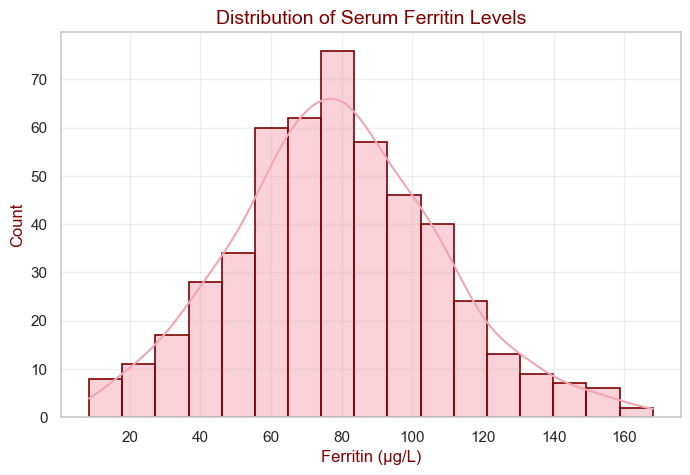

In [ ]:
sns.set_theme(style="whitegrid")
pink_palette = ["#f2a6b3", "#f5c6cb", "#f8d7da", "#f1b0b7", "#e83e8c"]
maroon = "#800000"

# 1️⃣ Ferritin distribution
plt.figure(figsize=(8, 5))
sns.histplot(simulated_df["Ferritin"], kde=True, color="#f2a6b3", edgecolor=maroon, linewidth=1.2)
plt.title("Distribution of Serum Ferritin Levels", color=maroon, fontsize=14)
plt.xlabel("Ferritin (µg/L)", color=maroon)
plt.ylabel("Count", color=maroon)
plt.grid(alpha=0.3)
plt.show()



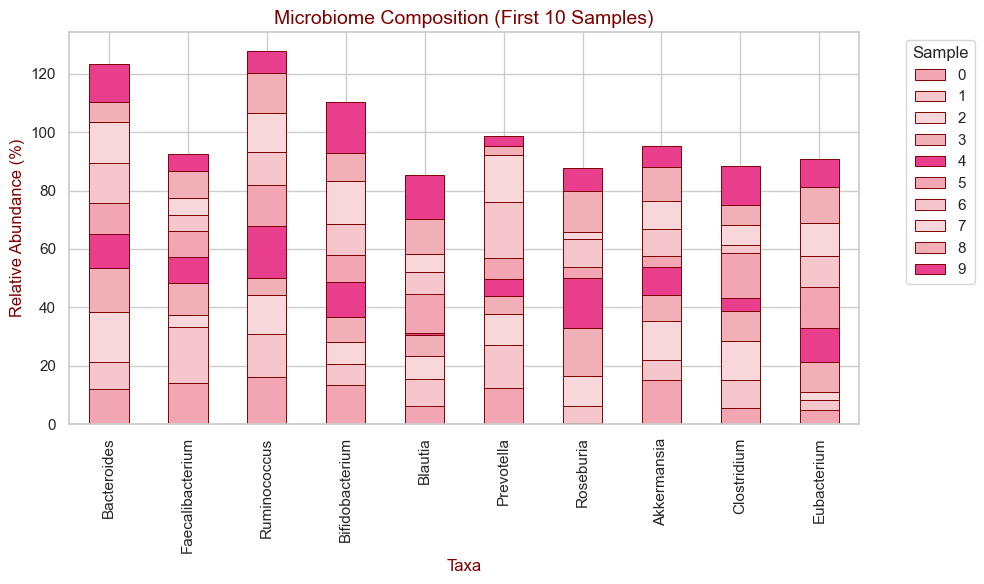

In [ ]:
# 2️⃣ Microbiome composition (stacked bar)
simulated_df[genera].iloc[:10].T.plot(
    kind="bar", stacked=True, figsize=(10, 6), 
    color=pink_palette, edgecolor=maroon, linewidth=0.7
)
plt.title("Microbiome Composition (First 10 Samples)", color=maroon, fontsize=14)
plt.ylabel("Relative Abundance (%)", color=maroon)
plt.xlabel("Taxa", color=maroon)
plt.legend(bbox_to_anchor=(1.05, 1), title="Sample")
plt.tight_layout()
plt.show()



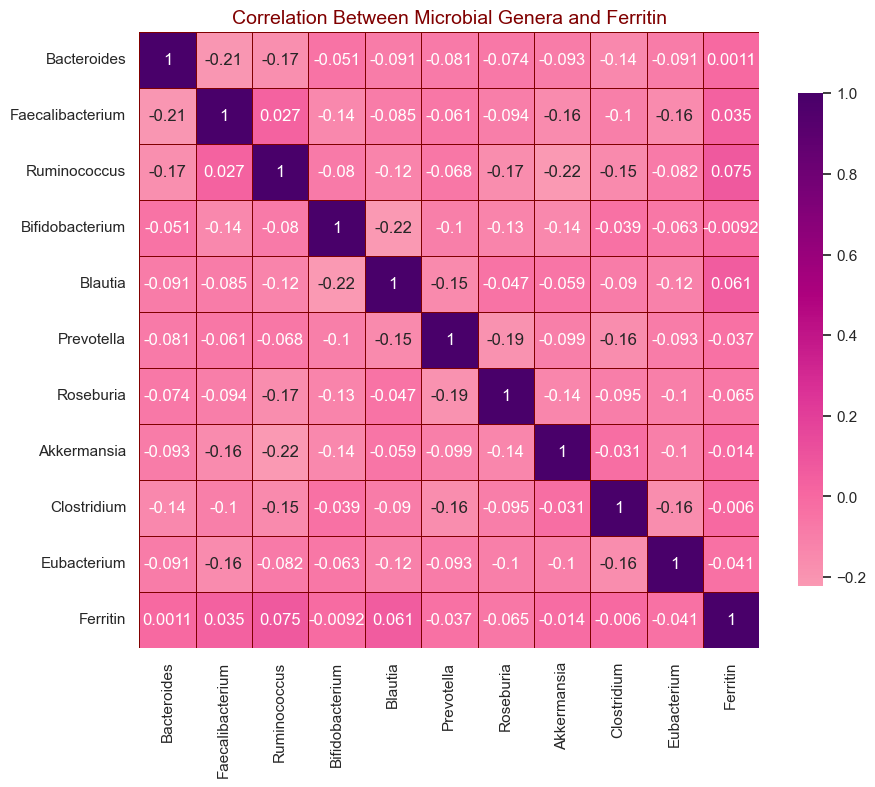

In [ ]:
# 3️⃣ Correlation heatmap
corr = simulated_df[genera + ["Ferritin"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr, annot=True, cmap="RdPu", center=0, 
    linewidths=0.5, linecolor=maroon, cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Between Microbial Genera and Ferritin", color=maroon, fontsize=14)
plt.show()

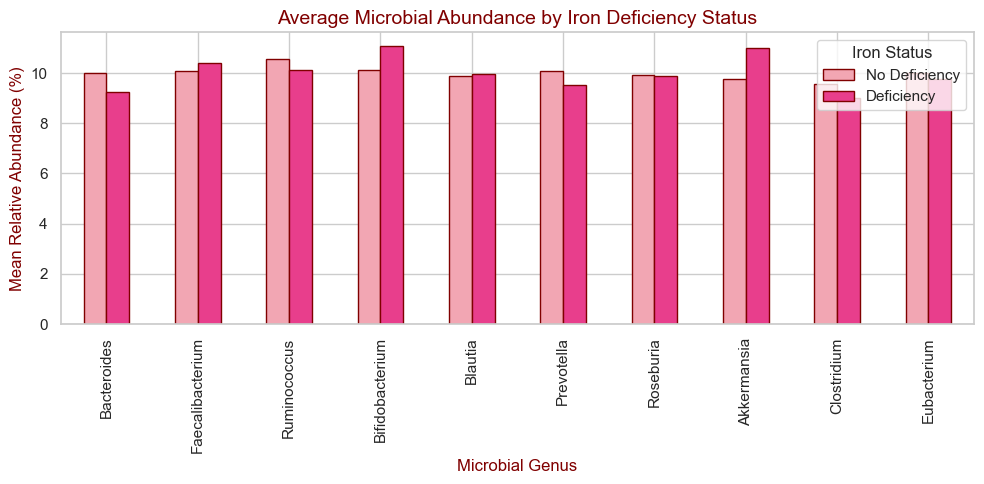

In [ ]:
# 4️⃣ Microbiome vs iron deficiency
avg_abundance = simulated_df.groupby("Iron_Deficiency")[genera].mean().T
avg_abundance.plot(
    kind="bar", figsize=(10, 5), color=["#f2a6b3", "#e83e8c"], 
    edgecolor=maroon, linewidth=1
)
plt.title("Average Microbial Abundance by Iron Deficiency Status", color=maroon, fontsize=14)
plt.ylabel("Mean Relative Abundance (%)", color=maroon)
plt.xlabel("Microbial Genus", color=maroon)
plt.legend(["No Deficiency", "Deficiency"], title="Iron Status")
plt.tight_layout()
plt.show()